Analyzing Media Coverage Of Other Countries in Austria
===


The aim of this project is to find out how reporting in Austria's print media about certain countries has changed over time (sentiment, which topics). In two further steps, I would also like to go down to the level of the individual newspapers and their authors and take an explorative look at whether there are tendencies/bias here. As countries of interest I choose Balkan countries because of their proximity to Austria and their long history of conflict.

    Text corpora: Austrian newspaper articles (or their respective twitter posts)
    Language: German
    Time: 2000–2022
    Method: Adding country labels to the articles, Sentiment Scores (, extracting underlying topics of the articles, e.g. with fuzzy topic modeling) 
    
According to https://de.wikipedia.org/wiki/Liste_%C3%B6sterreichischer_Zeitungen_und_Zeitschriften derstandard.at and krone.at reach the most people online, they also cover Austrian society quite well. So, initially, I will focus on these two and might add some more newspapers at a later stage.

* Focus on 2 countries: Serbia and Croatia (like Austria now a EU country)
* I will label an article with "Serbia" if the ratio of amount of words that relate to "Serbia"  compared to words that relate to "Croatia" is greater than 4
* I will also try to find out if there are certain authors who are responsible for a certain tendency.
* Another analysis could be build upon the ratio of "Serbia" and "Albania" or "Kosovo"

**Hypothesis 1: Tweets about Croatia are on average more positive than tweets about Serbia**

Inspiration:
https://www.brookings.edu/blog/africa-in-focus/2017/08/08/exploring-media-sentiment-around-africa-country-analysis/

In [1]:
import jupyter_black

jupyter_black.load()

In [8]:
import os
import json
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from bs4 import BeautifulSoup
import requests


data_dir = "data/twitter"

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)


def dl_user(user, max_results=None, local=False):
    """
    Function to download tweets by username.
    Set local to True, if tweets have already
    been downloaded and are available in data_dir.

    Returns a DataFrame.

    """

    if local == False:
        with open(data_dir + f"/user-{user}.json", "w+") as fo:
            if max_results == None:
                cmd_list = ["snscrape", "--jsonl", "twitter-user", user]
            else:
                cmd_list = [
                    "snscrape",
                    "--jsonl",
                    "-n " + str(max_results),
                    "twitter-user",
                    user,
                ]
            p = subprocess.Popen(cmd_list, stdout=fo)
            p.wait()

    with open(data_dir + f"/user-{user}.json", "r") as fo:
        tweets = fo.readlines()

    tweets = [json.loads(tweets[i]) for i in range(0, len(tweets))]
    print("loaded", len(tweets), "tweets\n")

    df_tweets = pd.DataFrame(tweets)
    df_tweets["date"] = pd.to_datetime(df_tweets["date"])

    return df_tweets[["date", "rawContent"]]

# 1. Scraping newspaper articles

## 1.1. derStandard.at


In [9]:
df_tweets = dl_user("derstandardat", max_results=None, local=True)

df_tweets.head()

loaded 272281 tweets



,date,rawContent
0,2023-01-25 09:50:19+00:00,Massive Ausfälle bei Microsoft Teams und Outlo...
1,2023-01-25 09:50:18+00:00,"ÖSV-Techniktrainer Kroisleitner: ""Potenzial de..."
2,2023-01-25 09:50:17+00:00,"Leopard-Lieferung: Selenskyj will mehr als ""ze..."
3,2023-01-25 09:33:54+00:00,"""IBES"" 2023: Jana ist raus – Werden Sie sie ve..."
4,2023-01-25 09:04:32+00:00,Chanels Haute Couture: Show führte in den Zirk...


### Extract urls for complete articles

<div class="alert alert-warning">Takes ages! Speed this up!!!</div>

In [10]:
def get_url(txt):
    """
    Get url from tweet.

    """

    try:
        return re.search("(?P<url>https?://[^\s]+)", txt).captures()[0]
    except:
        return ""


from time import sleep


def get_direct_url(url):
    """
    Direct url

    """

    url_direct = None

    if url != "":
        while url_direct == None:
            print(".", end="")
            try:
                page = requests.get(
                    url, headers={"User-Agent": "Mozilla/5.0"}, timeout=(0.5, 27)
                )
                html = BeautifulSoup(page.text, "html.parser")
                url_direct = html.find("link")
                if url_direct == None:
                    url_direct = ""
                else:
                    url_direct = url_direct.get("href")
            except Exception as e:
                ...
        print("1", end="")

        sleep(0.5)

        return url_direct

    else:
        print("0", end="")
        return url

First tep: Get short url from text

In [11]:
%%time


df_tweets["url"] = df_tweets["rawContent"].apply(lambda x: get_url(x))

CPU times: user 2.8 s, sys: 9.62 ms, total: 2.81 s
Wall time: 2.81 s


### Preprocess text

<div class="alert alert-warning">Necessary?</div>

In [19]:
#
#
#

### Save to file

In [14]:
df_tweets.to_csv(data_dir + "/media_coverage_with_url.csv", index=False)

### Load from file

In [17]:
df_tweets = pd.read_csv(data_dir + "/media_coverage_with_url.csv")
df_tweets.tail()

,date,rawContent,url
272432,2009-05-13 13:14:27+00:00,"Mölzer im Chat: ""Kulturkampf zwischen Christen...",http://derStandard.at/EU
272433,2009-05-12 14:24:59+00:00,Morgen geht es weiter mit den EU-Chats. Andrea...,http://derStandard.at/EU
272434,2009-05-12 14:23:09+00:00,"""Wenn wir die EU nicht hätten, müssten wir sie...",NaN
272435,2009-03-26 16:16:10+00:00,"Neu: Permalinks für Postings, Artikel und Schw...",http://tinyurl.com/deqklo
272436,2009-03-26 15:49:04+00:00,First tweet!,NaN



### Compute sentiment scores for all tweets

#### Textblob

In [67]:
from textblob_de import TextBlobDE as TextBlob


df_tweets["sentiment_textblob"] = df_tweets.rawContent.apply(
    lambda x: TextBlob(x).polarity
)

Save

In [73]:
df_tweets.to_csv(data_dir + "/media_coverage_with_sentiment.csv", index=False)

Load

In [74]:
df_tweets = pd.read_csv(
    data_dir + "/media_coverage_with_sentiment.csv",
    parse_dates=["date"],
)
df_tweets.head()

,date,rawContent,url,sentiment_textblob
0,2023-01-25 09:50:19+00:00,Massive Ausfälle bei Microsoft Teams und Outlo...,https://t.co/8vICahGNxr,-1.0
1,2023-01-25 09:50:18+00:00,"ÖSV-Techniktrainer Kroisleitner: ""Potenzial de...",https://t.co/84r4nazixi,0.0
2,2023-01-25 09:50:17+00:00,"Leopard-Lieferung: Selenskyj will mehr als ""ze...",https://t.co/YnMS20JJ6X,0.0
3,2023-01-25 09:33:54+00:00,"""IBES"" 2023: Jana ist raus – Werden Sie sie ve...",https://t.co/RKk4pRXw1Y,0.0
4,2023-01-25 09:04:32+00:00,Chanels Haute Couture: Show führte in den Zirk...,https://t.co/mg2CIOEm7c,0.0


#### germansentiment

In [169]:
from germansentiment import SentimentModel

gsm = SentimentModel()


def german_sentiment(txt):
    """

    returns sentiment score for
    German language.

    """

    classes, [probs] = gsm.predict_sentiment([txt], output_probabilities=True)
    probs = dict(probs)

    return probs["positive"] - probs["negative"]

In [ ]:
%%time

df_tweets["sentiment_gs"] = df_tweets.rawContent.apply(
    lambda x: german_sentiment(x)
)

Save

In [ ]:
df_tweets.to_csv(data_dir + "/media_coverage_with_sentiment2.csv", index=False)

Load

In [ ]:
df_tweets = pd.read_csv(
    data_dir + "/media_coverage_with_sentiment2.csv",
    parse_dates=["date"],
)
df_tweets.head()

#### Flair (currently only classifies into OTHER and OFFENSIVE)

### Which countries are the tweets referring to (Serbia, Croatia)?

In [76]:
countries = dict(
    serbia=["serbien", "serbe", "serbin", "serbisch", "serbo"],
    croatia=["kroatien", "kroate", "kroatin", "kroatisch", "kroato"],
    romania=["rumänien", "rumäne", "rumänin", "rumänisch"],
    hungary=["ungarn", "ungar", "ungarin", "ungarisch", "ungaro"],
    finland=["finnland", "finne", "finnin", "finnisch", "finno"],
    norway=["norwegen", "norweger", "norwegisch"],
    sweden=["schweden", "schwedin", "schwedisch"],
    danmark=["dänisch", "dänen", "dänin", "dänisch"],
    poland=["polen", "pole", "polin", "polnisch"],
    bulgaria=["bulgarien", "bulgare", "bulgarin", "bulgarisch"],
    russia=["russland", "russe", "russin", "russen", "russisch"],
    ukraine=["ukraine", "ukrainisch"],
    germany=["deutschland", "deutsche"],
    frankreich=["frankreich", "franzose", "französi"],
    slovenia=["slowenien", "slowene", "sloweni"],
    italy=["italien"],
    spain=["spanien", "spanier", "spanisch"],
    portugal=["portual", "portugiese", "portugiesin", "portugiesisch"],
    switzerland=["schweiz"],
    austria=["österreich"],
    slovakia=["slowakei", "slowake", "slowakin", "slowakisch"],
    czechia=["tschechien", "tscheche", "tschechin", "tschechisch"],
    belarus=[
        "belarus",
        "weißrussland",
        "weissrussland",
        "weißrussisch",
        "weissrussisch",
        "weißrusse",
        "weissrusse",
        "weißrussin",
        "weissrussin",
    ],
    bosnia=["bosnien", "bosnisch", "herzegowina", "bosnier", "herzegowinisch"],
    montenegro=["montenegro", "montenegriner", "montenegrinisch"],
    albania=["albanien", "albaner", "albanisch"],
)

#### Function for finding tweets about countries

In [77]:
def get_country(df_tweets, country, not_country=None, and_country=None):
    """

    Filters DataFrame with tweets to country-
    specific tweets.

    Optional: Can exclude tweeds of specific other countries
    via not_country variable.

    """
    df_country = df_tweets[
        ["date", "rawContent", "url", "sentiment_vader", "sentiment_textblob"]
    ].copy()

    if not_country != None:

        df_country = df_country.loc[
            df_country.rawContent.str.lower().str.contains(
                "|".join(country), regex=True
            )
            & ~df_country.rawContent.str.lower().str.contains(
                "|".join(not_country), regex=True
            )
        ].reset_index(drop=True)

    else:
        df_country = df_country.loc[
            df_country.rawContent.str.lower().str.contains(
                "|".join(country), regex=True
            )
        ].reset_index(drop=True)

    return df_country

### Compare sentiments betweens countries

<div class="alert alert-warning">Something is messed up here! we have the tweet in the date field and the url in the hashtags field!</div>

In [79]:
df_scores = pd.DataFrame()

for key in countries.keys():
    df_scores_tmp = get_country(df_tweets, countries[key])[
        ["sentiment_vader", "sentiment_textblob"]
    ]
    count = len(df_scores_tmp)
    df_scores_tmp = pd.DataFrame(
        df_scores_tmp.mean(),
        columns=[key],
    ).T
    df_scores_tmp["count"] = count
    df_scores = pd.concat([df_scores, df_scores_tmp], sort=False)

df_scores = df_scores.reset_index().rename(columns={"index": "country"})

plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_scores,
    x="sentiment_vader",
    y="sentiment_textblob",
    hue="country",
    size="count",
    sizes=(40, 1600),
    legend=False,
    alpha=0.4,
)

for tup in df_scores.itertuples():
    plt.annotate(tup[1].upper(), (tup[2], tup[3]))

plt.tight_layout()

KeyError: "['sentiment_vader'] not in index"

#### Find tweets about Serbia (but not Croatia)

In [ ]:
%%time

df_serbien = get_country(df_tweets, countries["serbia"], countries["croatia"])
df_serbien["direct_url"] = df_serbien["url"].apply(lambda x: get_direct_url(x))

df_serbien.head()

#### Find tweets about Croatia (but not Serbia)

In [ ]:
%%time

df_kroatien = get_country(df_tweets, countries["croatia"], countries["serbia"])
df_kroatien["direct_url"] = df_kroatien["url"].apply(lambda x: get_direct_url(x))

df_kroatien.head()

#### Find tweets about both Serbia and Croatia

In [ ]:
%%time

df_both = df_tweets[
    ["date", "rawContent", "sentiment_vader", "sentiment_textblob", "url"]
].copy()

df_both = df_both.loc[
    df_both.rawContent.str.lower().str.contains(
        "|".join(countries["croatia"]), regex=True
    )
    & df_both.rawContent.str.lower().str.contains(
        "|".join(countries["serbia"]), regex=True
    )
].reset_index(drop=True)
df_both["direct_url"] = df_both["url"].apply(lambda x: get_direct_url(x))

print(len(df_both), "tweets")

df_both.head()

Save

In [ ]:
df_both.to_csv(data_dir + "/df_both.csv", index=False)
df_serbien.to_csv(data_dir + "/df_serbien.csv", index=False)
df_kroatien.to_csv(data_dir + "/df_kroatien.csv", index=False)

Load

In [ ]:
df_both = pd.read_csv(data_dir + "/df_both.csv")
df_serbien = pd.read_csv(data_dir + "/df_serbien.csv")
df_kroatien = pd.read_csv(data_dir + "/df_kroatien.csv")

#### Controls: Find tweets about other countries (Romania, Hungary, Finland)

In [ ]:
df_rumanien = get_country(df_tweets, countries["romania"])


df_rumanien.head()

In [ ]:
df_ungarn = get_country(df_tweets, countries["hungary"])


df_ungarn.head()

In [ ]:
df_finnland = get_country(df_tweets, countries["finland"])


df_finnland.head()

In [ ]:
from scipy.stats import ttest_ind
from pingouin import ttest

*t*-Test

In [ ]:
ttest(
    df_kroatien.sentiment_textblob, df_serbien.sentiment_textblob, alternative="greater"
)

Permutation test

In [ ]:
ttest_ind(
    df_kroatien.sentiment_textblob,
    df_serbien.sentiment_textblob,
    permutations=100_000,
    alternative="greater",
)

<div class="alert alert-info">More positive coverage of Croatia over Serbia is significant, but the difference is small.</div>

*t*-Tests vs baseline

In [ ]:
df_tweets["sentiment_textblob"] = df_tweets.rawContent.apply(
    lambda x: TextBlob(x).polarity
)

df_tweets.sentiment_textblob.mean()

In [ ]:
ttest_ind(df_kroatien.sentiment_textblob, df_tweets.sentiment_textblob)

In [ ]:
ttest_ind(df_serbien.sentiment_textblob, df_tweets.sentiment_textblob)

### Scrape the complete articles

In [ ]:
from bs4 import BeautifulSoup


def get_text(url):
    try:
        soup = BeautifulSoup(requests.get(url).content, "html.parser")
        txt = soup.find_all("div", class_="article-text")[0].text
    except:
        txt = ""
    return txt


df_both["article_text"] = df_both["direct_url"].apply(lambda x: get_text(x))
df_serbien["article_text"] = df_serbien["direct_url"].apply(lambda x: get_text(x))
df_kroatien["article_text"] = df_kroatien["direct_url"].apply(lambda x: get_text(x))

Save

In [ ]:
df_both.to_csv(data_dir + "/df_both_with_article_short.csv", index=False)
df_serbien.to_csv(data_dir + "/df_serbien_with_article_short.csv", index=False)
df_kroatien.to_csv(data_dir + "/df_kroatien_with_article_short.csv", index=False)

Load

In [139]:
df_both = pd.read_csv(data_dir + "/df_both_with_article_short.csv")
df_serbien = pd.read_csv(data_dir + "/df_serbien_with_article_short.csv")
df_kroatien = pd.read_csv(data_dir + "/df_kroatien_with_article_short.csv")

Some preprocessing. Maybe this has to be fixed. Evaluate only sentence by sentence and make this column a list of sentence? Adapt the functions fo building the sentiment scores then.

In [149]:
df_serbien["article_text"] = df_serbien.article_text.fillna("")
df_kroatien["article_text"] = df_kroatien.article_text.fillna("")
df_both["article_text"] = df_both.article_text.fillna("")

df_serbien["article_text"] = df_serbien.article_text.str.replace("\n", "")
df_kroatien["article_text"] = df_kroatien.article_text.str.replace("\n", "")
df_both["article_text"] = df_both.article_text.str.replace("\n", "")

### Compute the sentiment scores for articles

In [249]:
df_serbien["sentiment_textblob_2"] = df_serbien.article_text.apply(
    lambda x: TextBlob(x).polarity
)

df_serbien["sentiment_flair_2"] = df_serbien.article_text.apply(
    lambda x: get_flair_score(x)
)

df_kroatien["sentiment_textblob_2"] = df_kroatien.article_text.apply(
    lambda x: TextBlob(x).polarity
)

df_kroatien["sentiment_flair_2"] = df_kroatien.article_text.apply(
    lambda x: get_flair_score(x)
)

df_both["sentiment_textblob_2"] = df_both.article_text.apply(
    lambda x: TextBlob(x).polarity
)

df_both["sentiment_flair_2"] = df_both.article_text.apply(lambda x: get_flair_score(x))

Build means

In [250]:
df_serbien[["sentiment_vader_2", "sentiment_textblob_2", "sentiment_flair_2"]].mean()

sentiment_vader_2      -0.376056
sentiment_textblob_2    0.013540
sentiment_flair_2       0.500000
dtype: float64

In [251]:
df_kroatien[["sentiment_vader_2", "sentiment_textblob_2", "sentiment_flair_2"]].mean()

sentiment_vader_2      -0.363010
sentiment_textblob_2    0.023413
sentiment_flair_2       0.500000
dtype: float64

In [252]:
df_both[["sentiment_vader_2", "sentiment_textblob_2", "sentiment_flair_2"]].mean()

sentiment_vader_2      -0.196267
sentiment_textblob_2   -0.032222
sentiment_flair_2       0.500000
dtype: float64

Compute means by year and plot

In [253]:
df_serbien["year"] = pd.to_datetime(df_serbien.date).dt.year
df_kroatien["year"] = pd.to_datetime(df_kroatien.date).dt.year
df_both["year"] = pd.to_datetime(df_both.date).dt.year

df_serbien_grp = (
    df_serbien.groupby("year")
    .mean()[["sentiment_textblob_2", "sentiment_vader_2", "sentiment_flair_2"]]
    .reset_index()
)

df_kroatien_grp = (
    df_kroatien.groupby("year")
    .mean()[["sentiment_textblob_2", "sentiment_vader_2", "sentiment_flair_2"]]
    .reset_index()
)

df_both_grp = (
    df_both.groupby("year")
    .mean()[["sentiment_textblob_2", "sentiment_vader_2", "sentiment_flair_2"]]
    .reset_index()
)

df_both_grp["country"] = "both"
df_serbien_grp["country"] = "serbia"
df_kroatien_grp["country"] = "croatia"

df_grp = pd.concat([df_serbien_grp, df_kroatien_grp], sort=False)

<AxesSubplot:xlabel='year', ylabel='sentiment_textblob_2'>

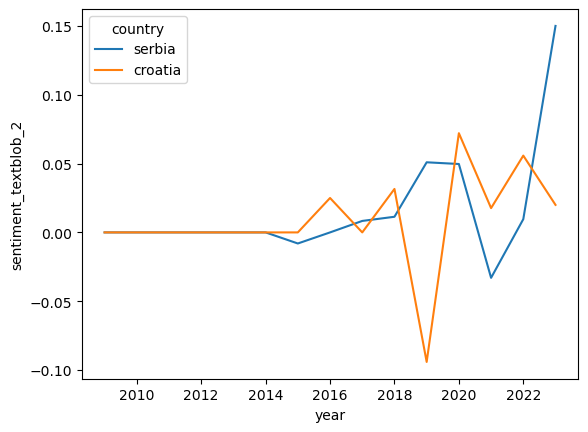

In [254]:
sns.lineplot(data=df_grp, x="year", y="sentiment_textblob_2", hue="country")

<AxesSubplot:xlabel='year', ylabel='sentiment_vader_2'>

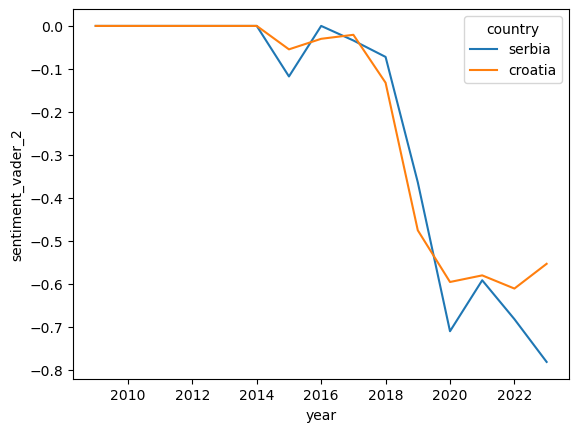

In [255]:
sns.lineplot(data=df_grp, x="year", y="sentiment_vader_2", hue="country")

using 0 form missing values is not a good decisions

In [256]:
df_grp.sentiment_flair_2 = df_grp.sentiment_flair_2.fillna(0)

<AxesSubplot:xlabel='year', ylabel='sentiment_flair_2'>

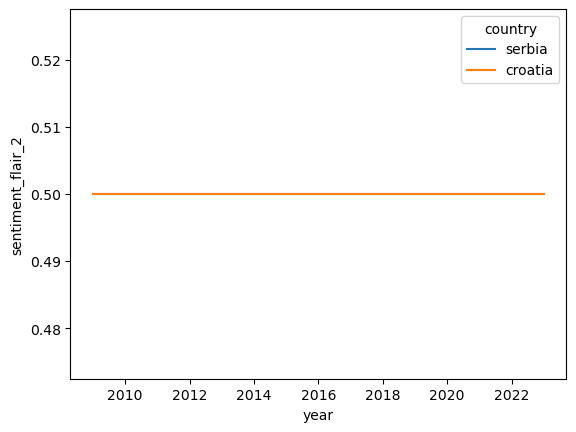

In [257]:
sns.lineplot(data=df_grp, x="year", y="sentiment_flair_2", hue="country")